# Demo: Bayesian Parameter Estimation for a Model of Logistic Growth

### Recommended Reading

Greg Brunkhorst, Sanmitra Ghosh, Demetri Pananos, and the PyMC Team, "ODE Lotka-Volterra With Bayesian Inference in Multiple Ways", code demo available at https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html

Gerda de Vries, Thomas Hillen, Mark Lewis, Johannes Müller, Birgitt Schönfisch, *A Course in Mathematical Biology*, SIAM, 2006. https://epubs.siam.org/doi/book/10.1137/1.9780898718256

Georgy Gause, *The Struggle for Existence*, Dover, 1971. Reprint of the 1934 edition published by The Williams \& Wilkins Co. https://store.doverpublications.com/0486838293.html

Nathaniel Linden, Boris Kramer, and Padmini Rangamanim, "Bayesian parameter estimation for dynamical models in systems biology", PLoS Comput. Biol. 18(10): e1010651. https://doi.org/10.1371/journal.pcbi.1010651

In this demo, we use a Bayesian approach to estimate various parameters governing the logistic growth of a population of unicellular organisms. The advantage of Bayesian methods is that uncertainty quantification for our parameter estimates is "baked-in". Additionally, Bayesian methods aren't too hard to implement in Python using the PyMC package. 

Our discussion is heavily based on the Jupyter tutorial by Brunkhorst et al. 

## Biological Background

NOTE: The content of this section is largely taken from my old demo on modelling with difference equations, available at https://github.com/ageorgemorgan/AdvMathClub2023/blob/main/pop_models_difference_eqns.ipynb . 

Georgy Gause was a Russian biologist active in the early twentieth century. He was interested in understanding the mathematical principles underlying evolution and population growth. 

Gause performed experiments on the growth of a laboratory population of *Paramecium aurelia* (https://en.wikipedia.org/wiki/Paramecium_aurelia) over twenty-six days. The paramecium population began with only a few cells, and was provided with a constant supply of nutrients.

I have made Gause's data (see pp. 144-145 of *The Struggle for Existence*) available on git as a single comma-separated value (CSV) file. Missing or ill-defined values are listed as NaN (not-a-number) in the file. When you downloaded the repository containing this notebook from github, the data file was automatically included. 

Additionally, following de Vries et al. p. 11, I made sure the data also included the change in density (note: there is a typo in de Vries et al. : the day 3 change should read 22, not 32). 

## Importing Packages + Loading Data

In [35]:
# The usual suspects...
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Stuff for Bayesian analysis
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az
import arviz.labels as azl

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

# make figure labels nice using tex (comment out if you don't have tex installed, or if it gives you trobule)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Once you've got the gause_data.csv file in your path (you can download this file from https://github.com/ageorgemorgan/AdvMathClub2023/blob/main/gause_data.csv), the data can be read with Pandas and plotted with Matplotlib: 

In [2]:
data = pd.read_csv("gause_data.csv") 
#display(data)

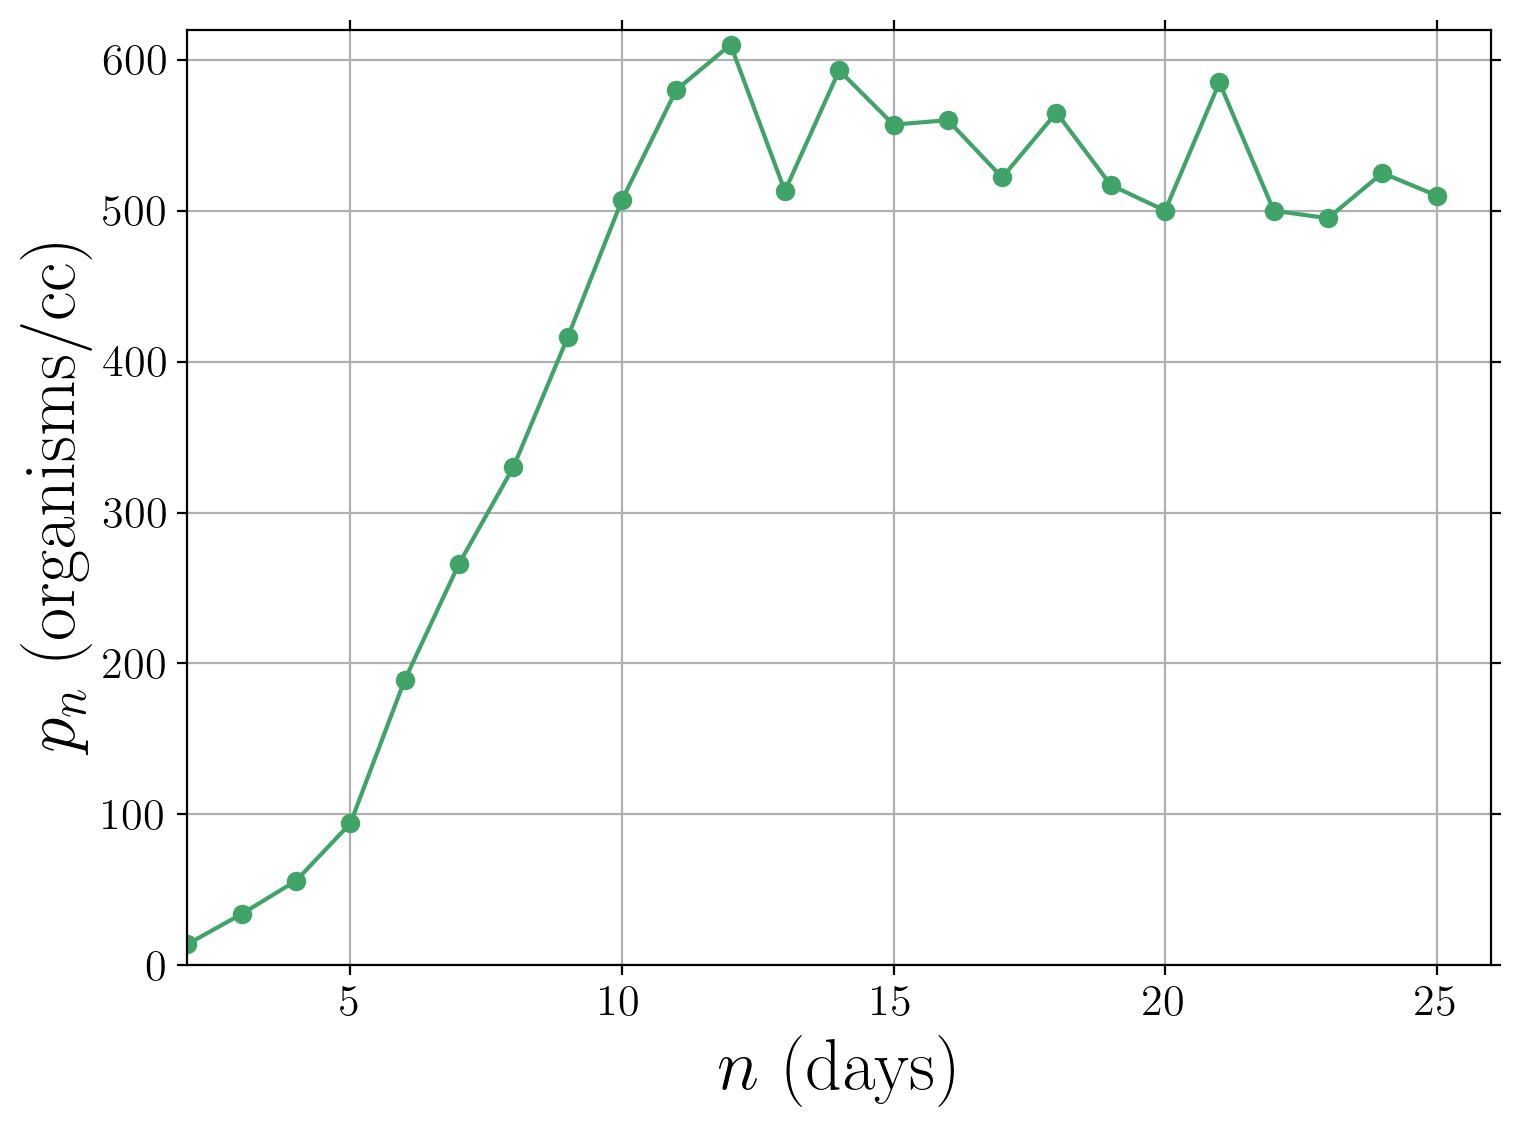

In [3]:
fig, ax =plt.subplots()

data['Density'].plot(marker='o', color='xkcd:greenish') 

plt.xlabel(r"$n$ (days)", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$ (organisms/cc)", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=12)
ax.locator_params(axis='x', nbins=8)

plt.frameon = True 
plt.grid(visible=True)

plt.xlim([2, 26])
plt.ylim([0, 620])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'gause_raw_data.jpg'
#plt.savefig(figname, dpi=600)

plt.show()

Here, $p_n$ denotes the number of organisms per cubic centimetre at day $n$. This plot shows that Gause observed **logistic growth**: an initially small amount of organisms reproduced quickly at first, then reached the "carrying capacity" of their environment and growth approximately stagnated. Our objective is to write down a simply mathematical model $n\mapsto p_n$ that provides a decent fit for this data. Note that, since the data from days $0$ and $1$ is not available, we treat day 2 as "time zero". This incurs a small amount of uncertainty in the "initial value" $p_0 = $ density at day 2, discussed further below. 

Before going further, let's extract the useful parts of the density data. 

In [4]:
dens =  data['Density'].to_numpy()
dens = dens[2:]

T = np.shape(dens)[0]
y = dens
y0=y[0]

## Model for Logistic Growth

Following the discussion in chapter 1 of de Vries et al., it's a good idea to model logistic growth using the **Beverton-Holt difference eqiation (BH)**. In terms of two parameters $b, L$, the dynamical update rule for the Beverton-Holt model reads 

$$
p_{n+1} = \frac{b}{1+\frac{b-1}{L}p_{n}} p_{n}. 
$$

This model has an unstable equilibrium at $0$ and an asymptotically stable equilibrium at $p_{*}=L$, the **carrying capacity**. 

Once you know the parameter values, simulating this model is trivial with a simple $\texttt{for}$ loop.

In [34]:
def sim(p0,b,L,T):
    
    p = np.zeros(T, dtype=float)

    p[0] = p0
    
    for n in range(1,T):
        
        p[n] = p[n-1]*(b*L)/(L+(b-1)*p[n-1])
        
    return p

Of course, we don't know the parameters $b,L$ *a priori*. We must therefore use the data to infer good parameter values. The first thing we might try is nonlinear regression of $\Delta p_{n}=p_{n+1}-p_{n}$ against $p_n$, performed in my old code notebook on Gause's experiment. This gives parameters yielding a good fit, but it doesn't tell how confident we should be in these parameter values: could slightly different parameters give us a similar or even better answer? To address this shortcoming, we instead use Bayesian parameter estimation here. 

## Implementation of Bayesian Parameter Estimation

Here, we discuss the details our method for parameter estimation. For theoretical background on Bayesian inference and its accompanying jargon, see for instance Linden et al.

To begin, let's talk about the parameters we need to estimate and any uncertainties in the data that introduce further parameters. First and most obviously, we need estimates for the parameters $b,L$ appearing in the BH model, along with useful error bounds on these estimates. Additionally, we must accept that Gause's measurements come with some uncertainty. To reflect this, we model the deviation of the observed data from the BH model prediction at each sampled time as a Gaussian random variable with variance $\sigma^2$. This introduces another parameter into the model that needs to be estimated! Also, the assumption of Gaussian noise gives us our rule for computing **likelihoods**, following Linden et al. Finally, since counting $\approx 500$ organisms in a cc is clearly more uncertain that counting $14$ organisms in a cc, we still treat $p_0$ as uncertain *but* we do not assume $p_0$ is distributed like all the future data vs. model noise. A more refined parameter estimation procedure would have $\sigma^2$ change with time, or at least scale with the population size, but for now just treating time zero "specially" is satisfying.

To summarize, in our Bayesian approach we have four uncertain parameters to estimate:

1) the linear growth rate $b$;
2) the carrying capacity $L$;
3) the mildly uncertain initial population size $p_0$;
4) the variance of the noise in observations of the population size $\sigma^2$.

Now, let's talk about priors. For $b,L$, we could take Gaussians with means given by naive curve fit-based parameter estimation, but to illustrate how much data can help improve a hypothesis we'll simply take uniform priors:

$$
b\sim \text{Unif}(1,10), \quad L\sim \text{Unif}(400,600).
$$

Here, the particular support intervals are chosen on the principle of "it looks right". As for the uncertainty in the initial state $p_0$, we choose a narrow normal centred at Gause's measured value: 

$$
p_0 \sim \mathcal{N}\left(14, 1\right). 
$$

From the frequentist perspective this assumption roughly says that, at least $2/3$ of the time, Gause correctly counted the "time zero" population accurate to $\pm 1$ organism per cc. This is perhaps a bit of a pessimistic assessment of Gause's counting skills! 

Finally, for the unknown standard deviation of the noise, we choose a very half-normal distribution since we want a positive answer:

$$
\sigma \sim \left|\mathcal{N}\right|\left(0,40\right).
$$

Again, the particular factor of $40$ is chosen by the "it looks right" principle: it's reasonable to see that the noisy part of the data typically jumps up or down by some number in the ball park of $40$. 

For fussy software reasons, we first need to wrap our model simulation function (forward solver) as a PyTensor operator. Otherwise, we won't be able to feed our parameters (which are PyMC $\texttt{RandomVariables}$) into the simulation. 

In [6]:
@pytensor.compile.ops.as_op(itypes=[pt.dvector], otypes=[pt.dvector]) # note: both are dvectors!!! this will change for bigger systems
def pytensor_forward_model(theta):
    return sim(theta[-1],theta[0],theta[1],T)

With that, actually specifying the model is easy: put in your priors and likelihood, and PyMC gets your posterior for you with no trouble. 

In [74]:
model = pm.Model()

with model:
    # make prior distributions
    b = pm.Uniform("b", lower = 1., upper=10.)# linear growth rate
    L = pm.Uniform("L", lower=400, upper=600) # carry capacity
    p0 = pm.Normal("p0", mu=y0, sigma=1.) # minor uncertainty in initial state
    theta = [b,L,p0]
    sigma = pm.HalfNormal("sigma", sigma = 40.) # noise in measurements
    
    mu = pytensor_forward_model(pm.math.stack([b,L,p0]))

    cov = (sigma**2)*np.eye(T)
    
    Y = pm.MvNormal("Y", mu=mu, cov=cov, observed=y)

Now, we draw samples from the posterior (using Markov Chain Monte Carlo simulation, under the hood in PyMC) and look at some smoothed histograms of the parameter values. These plots are made with arviz, which is great for building plots during the exploration phase of an investigation but doesn't quite give the user enough control to easily create publication-quality figures. 

In [75]:
with model:
    numsamples=1000 # if you really need convincing that Monte Carlo works, then crank the num. of steps way up!
    idata = pm.sample(numsamples) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [b]
>>Slice: [L]
>>Slice: [p0]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


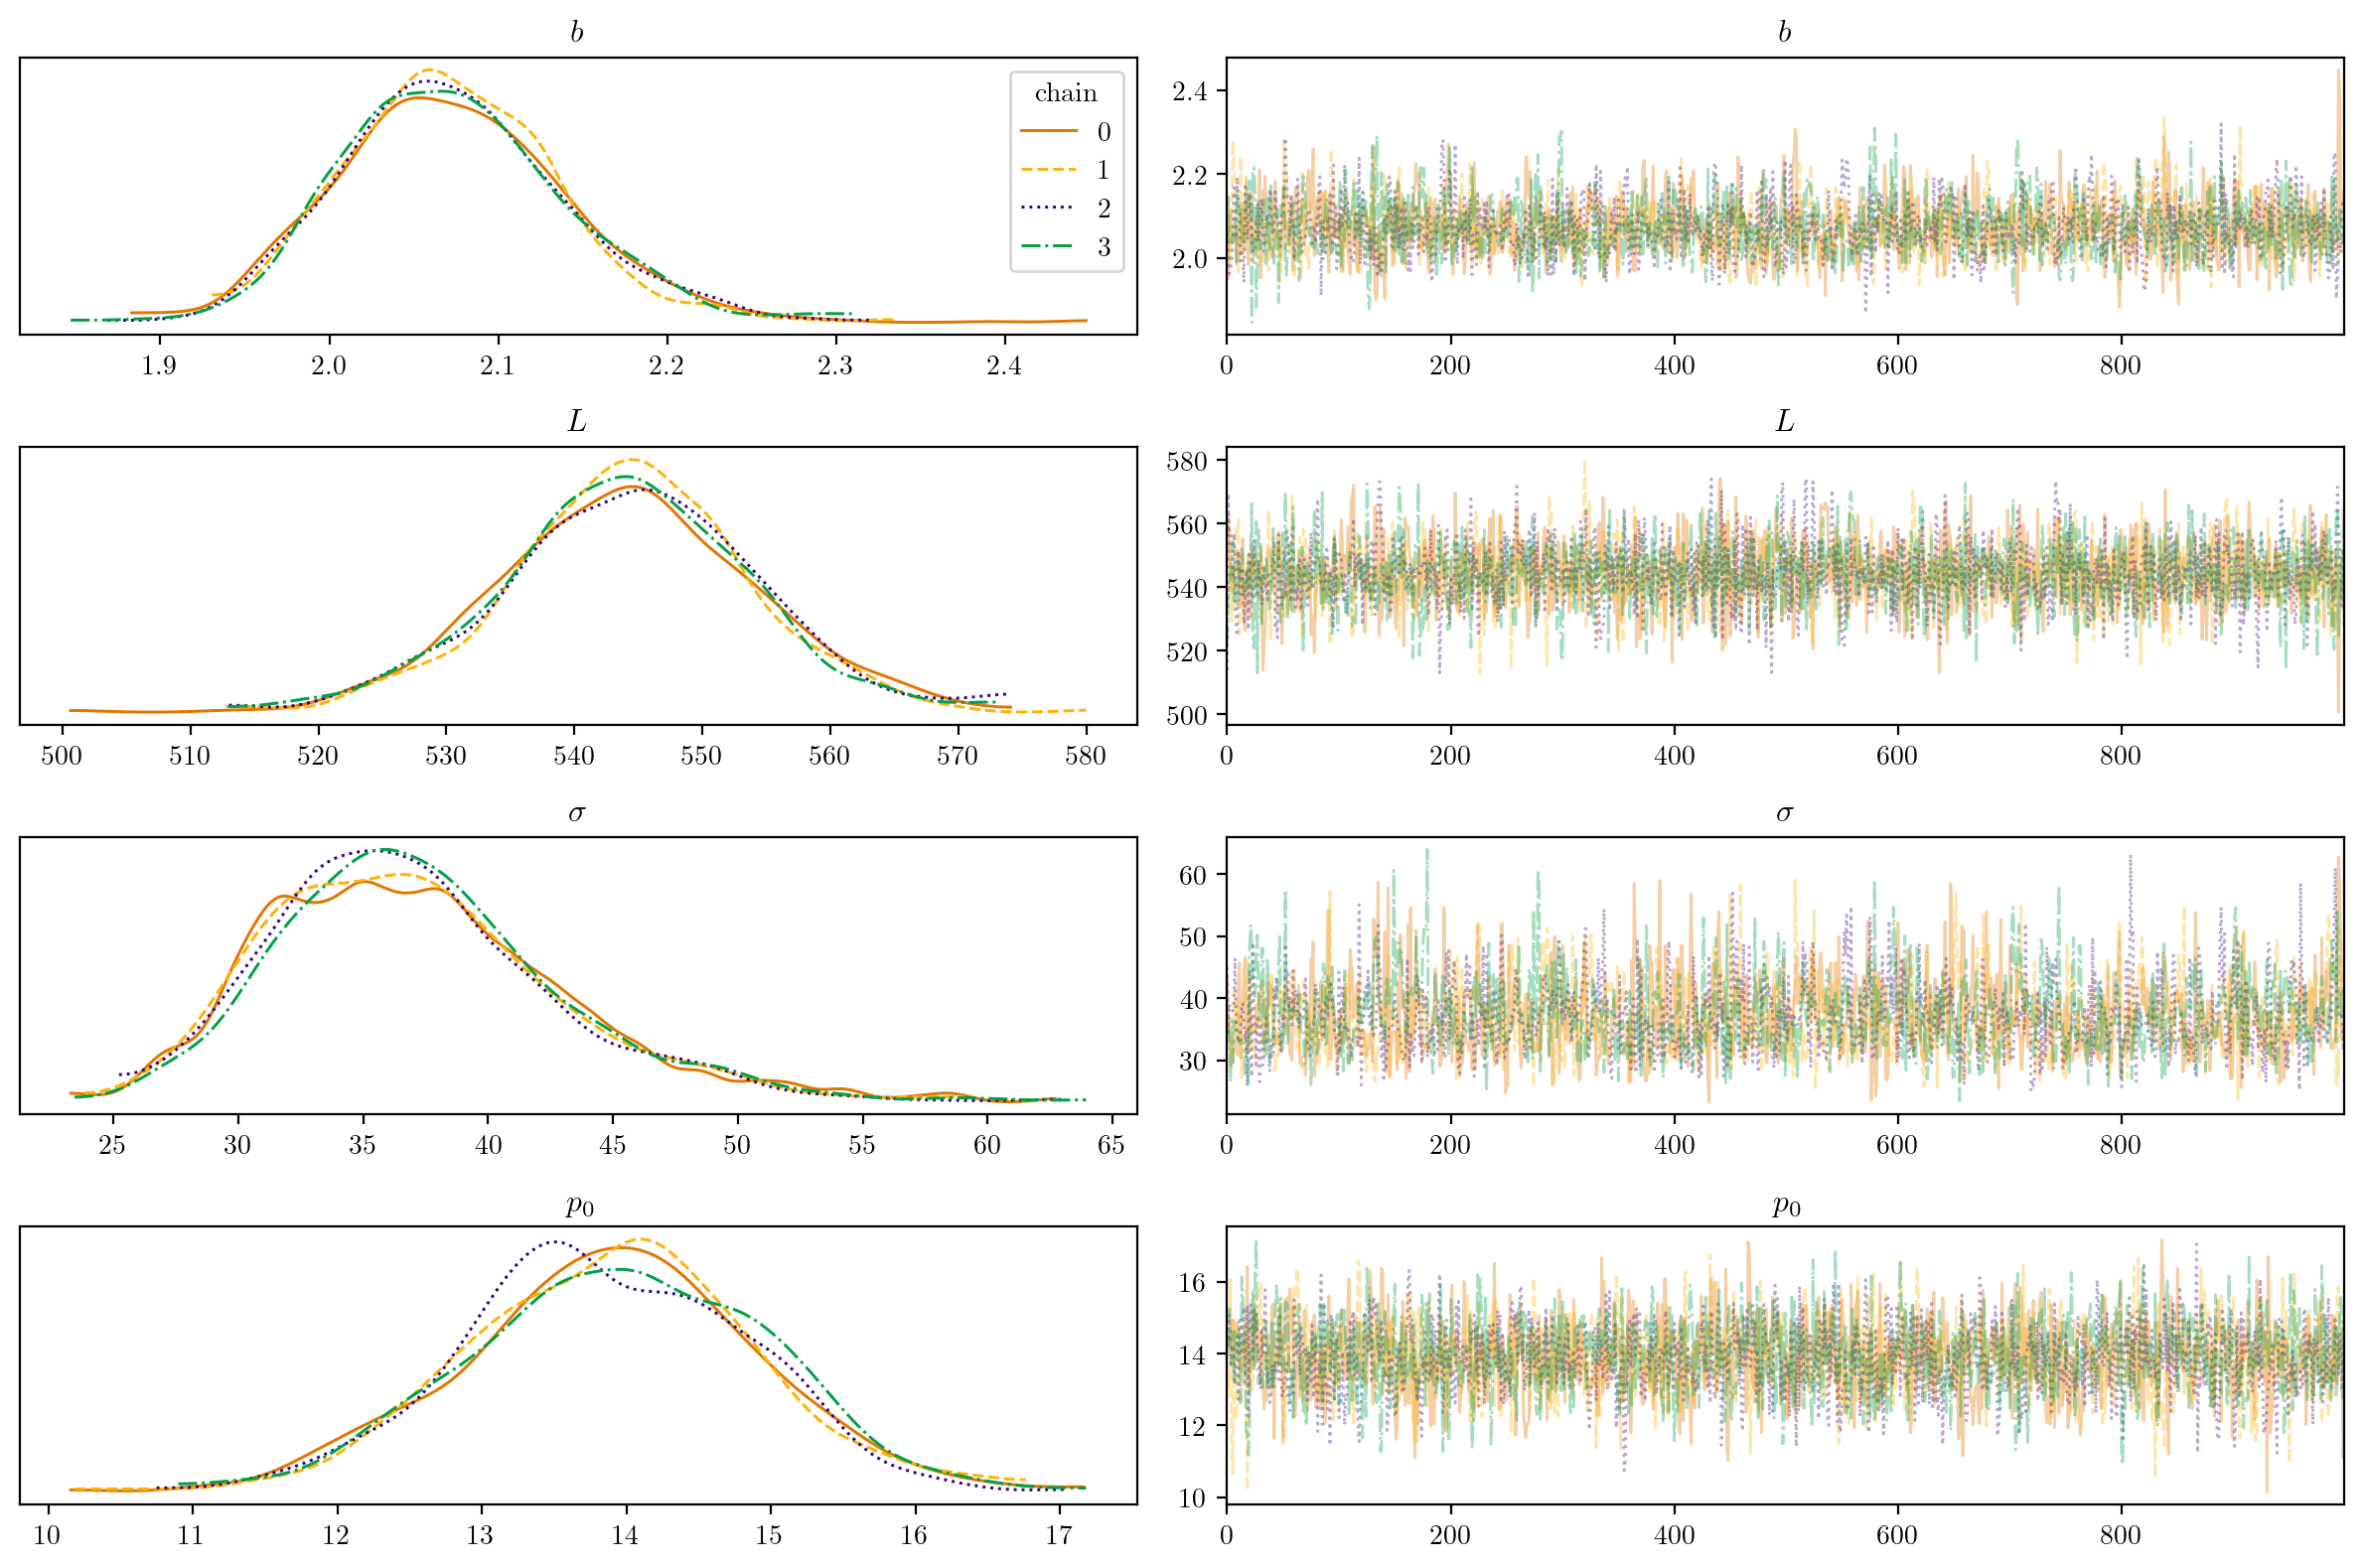

In [76]:
chain_prop = {"color": ['xkcd:pumpkin', 'xkcd:saffron', 'xkcd:indigo', "xkcd:emerald"], "linestyle":['-', '--',  ':', '-.']}
var_names=["b", "L", "sigma", "p0"]
labeller = azl.MapLabeller(var_name_map={"b":r"$b$", "L":r"$L$", "sigma":r"$\sigma$", "p0":r"$p_0$"})
az.plot_trace(idata, compact=True, legend=True, chain_prop=chain_prop, var_names=var_names, labeller=labeller);
plt.tight_layout()

Notice how each Markov chain the sampler tried gave rise to roughly the same histogram, which is a nice way to check that the results are "correct" (at the very least, convergent). Additionally, note that the very uninformative priors for $b$ and $L$ were moulded into nice Gaussians after learning from the data: Bayesian updating actually gave us new information! 

We can use arviz's handy $\texttt{summary}$ tool to get the mean of each parameter, among other diagnostic quantities. 

In [77]:
summary = az.summary(idata, round_to=3)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,13.893,0.995,11.964,15.643,0.019,0.014,2620.740,2560.007,1.001
b,2.072,0.066,1.956,2.196,0.001,0.001,2378.892,2405.591,1.001
L,544.247,9.698,525.777,563.170,0.174,0.123,3126.901,2468.772,1.001
sigma,37.049,5.768,27.157,48.514,0.138,0.098,1775.471,2365.921,1.002


It's reasonable to report the means of each quantity as our actual estimated parameter values. The uncertainty in these estimates can be quantified using the standard deviation (sd) or the high-density intervals (hdi) of each parameter. 

To visualize what sort of population growth curves our parameter values predict, let's plot the BH model with $p_0, b$, and $L$ values coming from some of the posterior samples we've just drawn. Note that these plots ignore the noise term: we're seeing how well exactly observable growth with uncertain parameters can explain the data. 

In [78]:
b_best = summary['mean']['b']
L_best = summary['mean']['L']
p0_best = summary['mean']['p0']
sigma_best = summary['mean']['sigma']

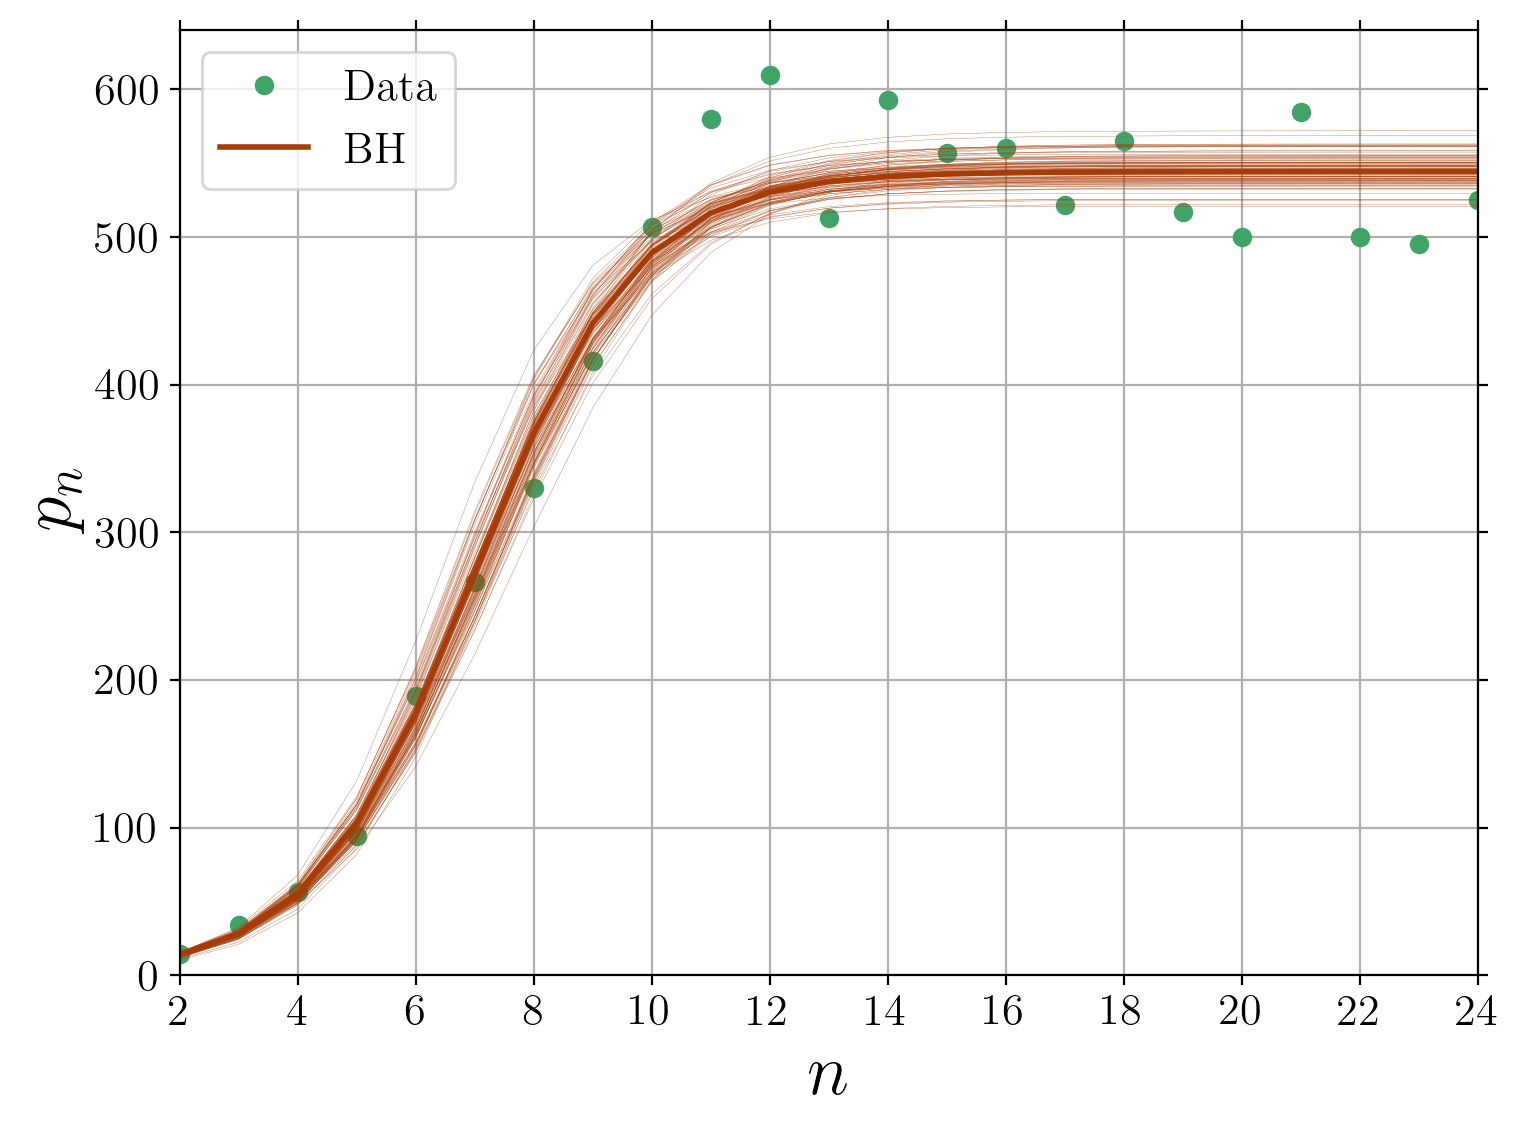

In [79]:
fig, ax =plt.subplots()   

plt.plot(np.arange(2,T+2), y, 'o', color='xkcd:greenish', label='Data')

# plot a bunch of other samples 
params = az.extract(idata, var_names=["b", "L", "p0", "sigma"], num_samples=100)
bb = np.array(params["b"])
LL = np.array(params["L"])
p0 = np.array(params["p0"])
sigma = np.array(params["sigma"])

#"""
for m in range(0, int(1e2)):

    xx = sim(p0[m], bb[m], LL[m], T) #+np.random.normal(scale=sigma[m], size=int(T))

    plt.plot(np.arange(2,T+2), xx, linestyle='solid', color='xkcd:rust', linewidth=0.1)
#"""

x_best = sim(p0_best, b_best, L_best, T)

plt.plot(np.arange(2,T+2), x_best, linestyle='solid', color='xkcd:rust', label='BH', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=12)
ax.locator_params(axis='x', nbins=16)

ax.legend(fontsize=16)

plt.xlim([2, 24])
plt.ylim([0, 1.05*np.amax(dens)])

plt.frameon = True 
plt.grid(visible=True)

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'bh_sim_best.png'
#plt.savefig(figname, dpi=600)

plt.show()

The simulation with the mean values of $p_0, b$, and $L$ is shown with the thickest line. The vast majority of our simulations, including those with the "best" parameter values, definitely appear to fit the data nicely. 

For further discussion on Bayesian parameter estimation in mathematical biology, see Linden et al. In the future, it would be interest to incorporate the filtering procedures described in this paper, or to scale the noise level $\sigma$ with the population size. Additionally, it would be informative to perform a **robustness analysis** where we estimate parameters using a *family* of priors rather than a single (albeit intuitively satisfying) set of priors. 